This notebook is a final project of the course FRE-GY7871. The objective of this project is to correctly classify the sentiment of financial text data into 3 classes: 'negative', 'neutral', 'positive'. Any sentences that are unrelated to finance should be classified as neutral.

This notebook is originally trained on Google Colab.

In [1]:
# Check for GPU
import tensorflow as tf
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
else:
    print(tf.config.list_physical_devices())
    print('\nCUDA GPU: ' + str(tf.test.is_gpu_available(cuda_only=True)))

We're running Colab


In [2]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive
  import os
  drive_root = mount + "/My Drive/FinalProject_kn2307/"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/FinalProject_kn2307/  exists.

Colab: Changing directory to  /content/gdrive/My Drive/FinalProject_kn2307/
/content/gdrive/My Drive/FinalProject_kn2307


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
# install required packages
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.6 MB/s eta 0:00

# 1. Data Exploration

## 1.1. Check dataset properties

Before taking an effort to import the financial_phasebank dataset from HuggingFace, I need to confirm the dataset's properties.

First, load the dataset description.

In [5]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("financial_phrasebank",'sentences_allagree')

# Inspect dataset description
ds_builder.info.description

'The key arguments for the low utilization of statistical techniques in\nfinancial sentiment analysis have been the difficulty of implementation for\npractical applications and the lack of high quality training data for building\nsuch models. Especially in the case of finance and economic texts, annotated\ncollections are a scarce resource and many are reserved for proprietary use\nonly. To resolve the missing training data problem, we present a collection of\n∼ 5000 sentences to establish human-annotated standards for benchmarking\nalternative modeling techniques.\n\nThe objective of the phrase level annotation task was to classify each example\nsentence into a positive, negative or neutral category by considering only the\ninformation explicitly available in the given sentence. Since the study is\nfocused only on financial and economic domains, the annotators were asked to\nconsider the sentences from the view point of an investor only; i.e. whether\nthe news may have positive, negat

Then, I inspect its features and label. The sentences in the dataset are labeled as 'negative', 'neutral, or 'positive'.

In [6]:
# Inspect dataset features
ds_builder.info.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [7]:
# Inspect dataset split names
from datasets import get_dataset_split_names

get_dataset_split_names("financial_phrasebank",'sentences_allagree')

['train']

## 1.2. Import the dataset

Import the "financial_phrasebank" dataset from HuggingFace and save it on local directory.

In [8]:
# import dataset 
from datasets import load_dataset
import os
from datasets import load_from_disk

dataset_path = './model_input/dataset/'

if not os.path.exists(dataset_path):
    # load dataset from huggingface
    with tf.device('/CPU:0'): # store the dataset on CPU
        dataset = load_dataset("financial_phrasebank",'sentences_allagree',split = 'train')
        dataset.save_to_disk(dataset_path)
else:
    # load dataset from local path
    with tf.device('/CPU:0'): # store the dataset on CPU
        dataset = load_from_disk(dataset_path)

In [9]:
dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2264
})

In [10]:
# count label
def countlabel(dataset):
    labelcount = {'0': 0, '1': 0, '2': 0}
    for i in range(dataset.shape[0]):
        label = dataset[i]['label']
        if label == 0:
            labelcount['0'] += 1
        elif label == 1:
            labelcount['1'] += 1
        elif label == 2:
            labelcount['2'] += 1
        else:
            pass
    return labelcount
  
countlabel(dataset)

{'0': 303, '1': 1391, '2': 570}

The dataset is imbalance with the majority labeled as 'neutral'.

# 2. Pre-trained Model Selection

I decided to use a pre-trained model "Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022)" from HuggingFace.
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

The model is based on RoBERTa-base. It was trained on approximatedly 124 million tweets from January 2018 to December 2021 and was finetuned for sentiment analysis with the TweetEval benchmark.

The reasons that I chose this model are as follows. 

First, it was originally trained for similar task which is to classify the sentiment into 3 classes: 'negative', 'neutral', and 'positive'. 

Second, it is based on RoBERTa. RoBERTa is a transformers model pretrained in a self-supervised fashion (pretrained on the raw texts only, with no humans labelling them). This makes it get access to publicly available data. Taking a sentence, the model randomly masks 15% of the words in the input which makes it understand bidirectional representation of the sentence. Therefore, it is especially suitable for the tasks that require understanding of the whole sentence like our sentiment classification task.


I download the model and its tokenizer from HuggingFace and save it on local path.

In [11]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import os

def load_pretrained_model():
  download_path = './cardiffnlp/twitter-roberta-base-sentiment-latest/'

  if not os.path.exists(download_path):
    print('load pre-trained model from HuggingFace')
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
    model.save_pretrained(MODEL)
    tokenizer.save_pretrained(download_path + 'tokenizer')
  else:
    # load model and tokenizer from local path
    print('load model from local path')
    model = TFAutoModelForSequenceClassification.from_pretrained(download_path)
    tokenizer = AutoTokenizer.from_pretrained(download_path + 'tokenizer')
    config = AutoConfig.from_pretrained(download_path)
  return model, tokenizer, config

model, tokenizer, config = load_pretrained_model()

load pre-trained model from HuggingFace


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
config

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.28.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [13]:
# test the model
text = "Covid cases are increasing fast!"
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)
scores = output[0][0].numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) positive 0.3581
2) neutral 0.3518
3) negative 0.2901


In [14]:
def count_weights(weights_per_layer, prefix=None):
  # NOTE: the .weights attributed DOES NOT include biases (available via .bias attribute)
  count_weights = 0

  for layer, weights in enumerate(weights_per_layer):
    num_weights = np.prod(weights.shape)

    if prefix is not None:
      print(f"Trainable layer {layer} has {num_weights} weights")

    count_weights += num_weights

  return count_weights

def count_model_weights(model):
  all_weights = model.weights
  trainable_weights = model.trainable_weights

  num_layers = len( model.layers )

  # Control detailed output: supress if number of layers (length of trainable_weights) is too big
  out_prefix = "trainable" if len(trainable_weights) < 10 else None

  num_weights, num_trainable_weights = count_weights(all_weights, None), count_weights(trainable_weights, out_prefix)                                                                         

  return num_weights, num_trainable_weights
  

In [15]:
num_weights, num_trainable_weights = count_model_weights(model)

print()
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")


Total number of weights 124,647,939, number of trainable weights 124,647,939


# 3. Data Preparation

## 3.1. Separate train and test set

I separate 20% of the dataset as a test set.

In [16]:
dataset = dataset.train_test_split(test_size=0.2)

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1811
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 453
    })
})

## 3.2. Align dataset label to match with the model

Since the original label does not align with the selected model's pretrained label. I create a dictionary mapping the label to the id prescribed in the model.

In [18]:
# Create label id
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
dataset = dataset.align_labels_with_mapping(label2id, "label")

Aligning the labels:   0%|          | 0/1811 [00:00<?, ? examples/s]

Aligning the labels:   0%|          | 0/453 [00:00<?, ? examples/s]

In [19]:
# Check the adjusted label
dataset['train'][0]

{'sentence': 'Pretax profit rose to EUR 1,019 mn from EUR 1,007 in the corresponding period in 2005 .',
 'label': 2}

## 3.3. Tokenization

map tokenized inputs to the original dataset 

In [20]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False)

In [21]:
import os 

if not os.path.exists('./model_input/tokenized_dataset/'):
    with tf.device('/CPU:0'): # store the dataset on CPU
        tokenized_dataset = dataset.map(tokenize_function, batched=True)
        tokenized_dataset.save_to_disk('./model_input/tokenized_dataset/')
else:
    # load saved tokenized dataset from local path
    with tf.device('/CPU:0'): # store the dataset on CPU
        tokenized_dataset = load_from_disk('./model_input/tokenized_dataset/')

Only 2 columns are generated ('input_ids' and 'attention_mask') because RoBERTa only uses these 2 variables.

In [22]:
tokenized_dataset['train'][0]

{'sentence': 'A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .',
 'label': 1,
 'input_ids': [0,
  250,
  4532,
  9,
  42206,
  6,
  17573,
  92,
  327,
  64,
  617,
  28,
  33339,
  13,
  30,
  20203,
  163,
  1735,
  223,
  5,
  4482,
  388,
  1973,
  563,
  479,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

## 3.5. Prepare tensor input

To minimize computational resources required, I implement dynamic padding (pad the tokenized data according to the max length within its batch). However, I do not apply any truncation to not lose any data. This is because the sentences are not too long.



In [23]:
from transformers import DataCollatorWithPadding
import os

if not os.path.exists('./model_input/tf_train/'):
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True, return_tensors="tf")

  tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=True,
      collate_fn=data_collator,
      batch_size=8,
  )
  tf.data.Dataset.save(tf_train_dataset, './model_input/tf_train/')
else:
  tf_train_dataset = tf.data.Dataset.load('./model_input/tf_train/')

if not os.path.exists('./model_input/tf_test/'):
  tf_validation_dataset = tokenized_dataset["test"].to_tf_dataset(
      columns=["attention_mask", "input_ids"],
      label_cols=["label"],
      shuffle=False,
      collate_fn=data_collator,
      batch_size=8,
  )
  tf.data.Dataset.save(tf_validation_dataset, './model_input/tf_test/')
else:
  tf_validation_dataset = tf.data.Dataset.load('./model_input/tf_test/')


# 4. Training

The model consists of 2 main layers: roberta (transformers) and the classifier head.

In [24]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


## 4.1. Model 1: Freeze Roberta

I start by freezing the roberta layer and train only the classification head.

In [25]:
model.roberta.trainable = False

In [26]:
num_weights, num_trainable_weights = count_model_weights(model)

print()
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Trainable layer 0 has 589824 weights
Trainable layer 1 has 768 weights
Trainable layer 2 has 2304 weights
Trainable layer 3 has 3 weights

Total number of weights 124,647,939, number of trainable weights 592,899


In [27]:
# Import time module
import time
 
# record start time
start = time.time()

model.compile(metrics = 'accuracy')
model.fit(tf_train_dataset,validation_data = tf_validation_dataset, epochs = 4)

# record end time
end = time.time()
 
# print the difference between start
# and end time in secs
print("Execution Time:",
      (end-start), "s")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/4
227/227 [==============================] - 43s 81ms/step - loss: 0.3964 - accuracy: 0.8459 - val_loss: 0.2441 - val_accuracy: 0.9227
Epoch 2/4
227/227 [==============================] - 15s 66ms/step - loss: 0.2958 - accuracy: 0.8857 - val_loss: 0.2259 - val_accuracy: 0.9249
Epoch 3/4
227/227 [==============================] - 15s 67ms/step - loss: 0.2774 - accuracy: 0.9001 - val_loss: 0.2173 - val_accuracy: 0.9294
Epoch 4/4
227/227 [==============================] - 18s 79ms/step - loss: 0.2409 - accuracy: 0.9078 - val_loss: 0.3314 - val_accuracy: 0.8896
Execution Time: 99.03610372543335 s


In [28]:
model.save_pretrained('./model/freeze-roberta/')

The performance is excellent with about 90% accuracy. I will discuss the result in detail later.

## 4.2. Model 2: Unfreeze All Layers

Next, I try unfreezing all layers to allow the weights of roberta to be trained.

In [29]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [30]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

download_path = './cardiffnlp/twitter-roberta-base-sentiment-latest/'

# load model and tokenizer from local path
model = TFAutoModelForSequenceClassification.from_pretrained(download_path)
tokenizer = AutoTokenizer.from_pretrained(download_path + 'tokenizer')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/twitter-roberta-base-sentiment-latest/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
model.trainable = True
model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


I use the exact tensor input as my previous model to make them comparable.

In [32]:
tf_train_dataset = tf.data.Dataset.load('./model_input/tf_train/')
tf_validation_dataset = tf.data.Dataset.load('./model_input/tf_test/')

In [33]:
# Import time module
import time
 
# record start time
start = time.time()

model.compile(metrics = 'accuracy')
model.fit(tf_train_dataset,validation_data = tf_validation_dataset, epochs = 4)

# record end time
end = time.time()
 
# print the difference between start
# and end time in secs
print("Execution Time:",
      (end-start), "s")


No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/4
227/227 [==============================] - 104s 251ms/step - loss: 0.9935 - accuracy: 0.5991 - val_loss: 0.9453 - val_accuracy: 0.6093
Epoch 2/4
227/227 [==============================] - 29s 127ms/step - loss: 0.9378 - accuracy: 0.6118 - val_loss: 0.9405 - val_accuracy: 0.6093
Epoch 3/4
227/227 [==============================] - 29s 127ms/step - loss: 0.9326 - accuracy: 0.6102 - val_loss: 0.9330 - val_accuracy: 0.6093
Epoch 4/4
227/227 [==============================] - 29s 127ms/step - loss: 0.9299 - accuracy: 0.6146 - val_loss: 0.9266 - val_accuracy: 0.6093
Execution Time: 214.64437413215637 s


In [34]:
model.save_pretrained('./model/roberta-unfreeze/')

It turns out that this time the performance is not as good. The model can only classify about 60% correctly.

# 5. Result Analysis

In this section, I will discuss in detail the results from the initial trial.

I loaded the exact tokenizer and and dataset used in the training.

In [35]:
from transformers import AutoTokenizer
download_path = './cardiffnlp/twitter-roberta-base-sentiment-latest/'
tokenizer = AutoTokenizer.from_pretrained(download_path + 'tokenizer')

In [36]:
from datasets import load_from_disk

# load saved tokenized dataset from local path
with tf.device('/CPU:0'): # store the dataset on CPU
    result = load_from_disk('./model_input/tokenized_dataset/')

For convenience, I created a function for generating model's predictions.

In [37]:
from scipy.special import softmax
import numpy as np

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False, return_tensors='tf')

def predict(example):
    encoded_input = tokenize_function(example)
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    example['predictions'] = ranking[0]
    return example

I dicided the use the following performance measures to compare the models.

1. sklearn's evaluation metrics

In [38]:
# evaluation metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

2. count number of labels associated to each class

In [39]:
def countlabel(labels, preds):
    predictions = []
    labelcount_predict = {'0': 0, '1': 0, '2': 0}
    labelcount_true = {'0': 0, '1': 0, '2': 0}
    for i in range(len(labels)):
        pred = preds[i]
        true = labels[i]
        if pred == 0:
            labelcount_predict['0'] += 1
        elif pred == 1:
            labelcount_predict['1'] += 1
        elif pred == 2:
            labelcount_predict['2'] += 1
        else:
            pass
        if true == 0:
            labelcount_true['0'] += 1
        elif true == 1:
            labelcount_true['1'] += 1
        elif true == 2:
            labelcount_true['2'] += 1
        else:
            pass
    labelcount = {}
    labelcount['predict'] = labelcount_predict
    labelcount['true'] = labelcount_true
    return labelcount

3. confusion matrix

In [40]:
# error analysis
# confusion matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def confusionMatrix(labels,preds):
  matrix = tf.math.confusion_matrix(
      labels = labels,
      predictions = preds,
      num_classes=3,
      weights=None,
      dtype=tf.dtypes.int32,
      name=None)
  return matrix

For convenience, I create a function to show all results at once.

In [41]:
def evaluate(labels, preds):
  metrics = compute_metrics(labels, preds)
  labelcount = countlabel(labels, preds)
  matrix = confusionMatrix(labels, preds)

  print('Evaluation Metrics:')
  for key in metrics:
    print(key + ': ',metrics[key] )
  print('\nLabel Counts:')
  for key in labelcount:
    print(key + ': ',labelcount[key])
  disp = ConfusionMatrixDisplay(confusion_matrix=np.array(matrix),
                            display_labels=model.config.label2id.keys())
  disp.plot()
  plt.show()

## 5.1. Model 0: Pre-trained Model

I generate the predictions using the original model before fine-tuning and assess its performance on the train set and test set that I used with other models.

In [42]:
model, tokenizer, config = load_pretrained_model()

from datasets import load_from_disk
import os

if not os.path.exists('./results/original-model/'):
  result = load_from_disk('./model_input/tokenized_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/original-model/')
else:
  result = load_from_disk('./results/original-model/')

load model from local path


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/twitter-roberta-base-sentiment-latest/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Train set:

Evaluation Metrics:
accuracy:  0.4395361678630591
f1:  [0.31738035 0.62256457 0.09037328]
precision:  [0.40909091 0.62912088 0.08141593]
recall:  [0.25925926 0.6161435  0.10154525]

Label Counts:
predict:  {'0': 154, '1': 1092, '2': 565}
true:  {'0': 243, '1': 1115, '2': 453}


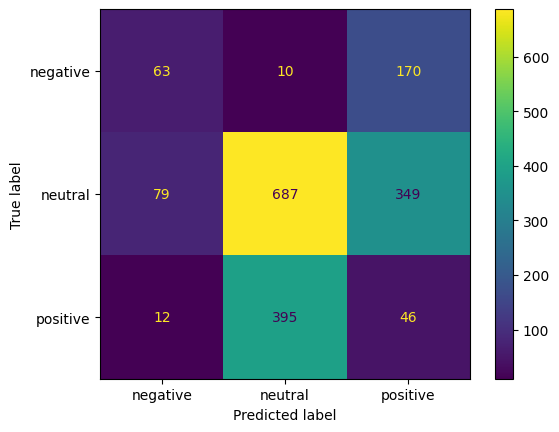

In [43]:
labels_train = np.array(result['train']['label'])
preds_train = np.array(result['train']['predictions'])
evaluate(labels_train,preds_train)

Test set:

Evaluation Metrics:
accuracy:  0.3995584988962472
f1:  [0.35051546 0.57826888 0.05263158]
precision:  [0.45945946 0.58801498 0.04697987]
recall:  [0.28333333 0.56884058 0.05982906]

Label Counts:
predict:  {'0': 37, '1': 267, '2': 149}
true:  {'0': 60, '1': 276, '2': 117}


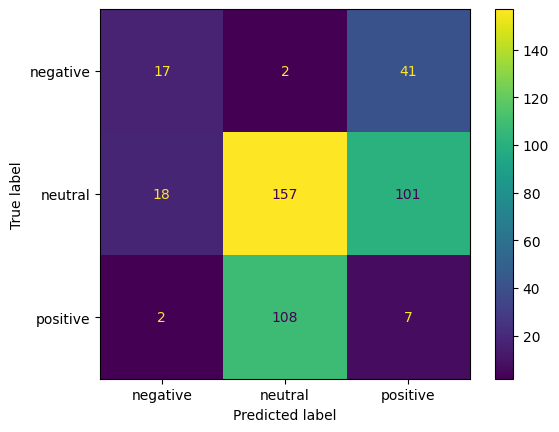

In [44]:
labels_test = np.array(result['test']['label'])
preds_test = np.array(result['test']['predictions'])
evaluate(labels_test,preds_test)

The original pre-trained model gives terrible result. It can only classifies less than half of both dataset correctly. As can be seen from the confusion matrices, it mistakenly classifies lots of negative sentences as positive, classifies neutral as positive, and classifies positive as neutral. This makes the original model useless for our task.

## 5.2. Model 1: Freeze Roberta

In [45]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained('./model/freeze-roberta/')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./model/freeze-roberta/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [46]:
from datasets import load_from_disk
import os

if not os.path.exists('./results/freeze-roberta/'):
  result = load_from_disk('./model_input/tokenized_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/freeze-roberta/')
else:
  result = load_from_disk('./results/freeze-roberta/')

Train set:

Evaluation Metrics:
accuracy:  0.9409166206515737
f1:  [0.88014981 0.97630755 0.88601645]
precision:  [0.80756014 0.97326203 0.94723618]
recall:  [0.96707819 0.9793722  0.83222958]

Label Counts:
predict:  {'0': 291, '1': 1122, '2': 398}
true:  {'0': 243, '1': 1115, '2': 453}


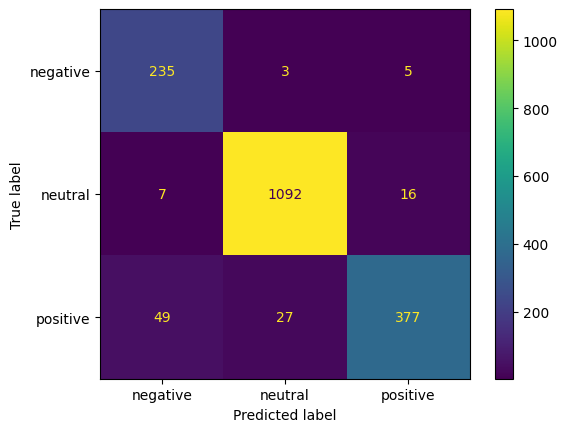

In [47]:
labels_train = np.array(result['train']['label'])
preds_train = np.array(result['train']['predictions'])
evaluate(labels_train,preds_train)

Test set:

Evaluation Metrics:
accuracy:  0.9249448123620309
f1:  [0.86131387 0.95810565 0.88181818]
precision:  [0.76623377 0.96336996 0.94174757]
recall:  [0.98333333 0.95289855 0.82905983]

Label Counts:
predict:  {'0': 77, '1': 273, '2': 103}
true:  {'0': 60, '1': 276, '2': 117}


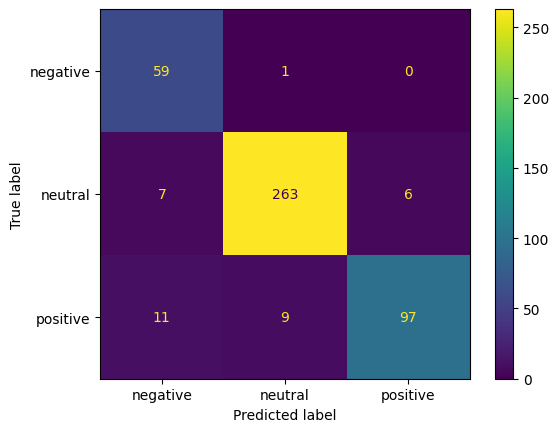

In [48]:
labels_test = np.array(result['test']['label'])
preds_test = np.array(result['test']['predictions'])
evaluate(labels_test,preds_test)

After training the classification head, the result is extremely good. According to the accuracy score, more than 90% of the samples are classified correctly. The fine-tuned model performs well to classify negative and neutral sentiment. No negative sentences are classified as positive anymore. However, its accuracy is a little bit less for true positive labels.

## 5.2. Model 2: Unfreeze All Layers

In [49]:
# model 2
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained('./model/roberta-unfreeze/')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./model/roberta-unfreeze/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [50]:
from datasets import load_from_disk
import os

if not os.path.exists('./results/roberta-unfreeze/'):
  result = load_from_disk('./model_input/tokenized_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/roberta-unfreeze/')
else:
  result = load_from_disk('./results/roberta-unfreeze/')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
accuracy:  0.6156819436775263
f1:  [0.        0.7621326 0.       ]
precision:  [0.         0.61568194 0.        ]
recall:  [0. 1. 0.]

Label Counts:
predict:  {'0': 0, '1': 1811, '2': 0}
true:  {'0': 243, '1': 1115, '2': 453}


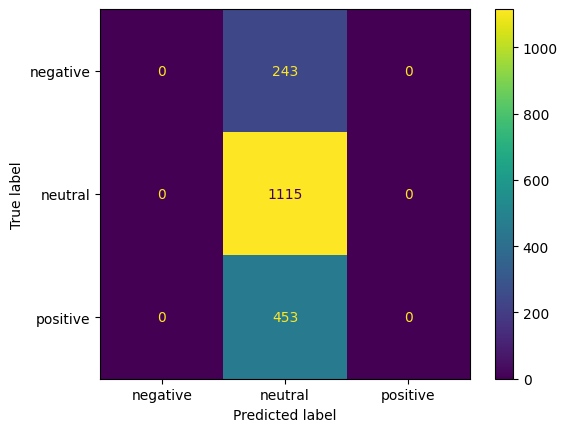

In [51]:
labels_train = np.array(result['train']['label'])
preds_train = np.array(result['train']['predictions'])
evaluate(labels_train,preds_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
accuracy:  0.609271523178808
f1:  [0.         0.75720165 0.        ]
precision:  [0.         0.60927152 0.        ]
recall:  [0. 1. 0.]

Label Counts:
predict:  {'0': 0, '1': 453, '2': 0}
true:  {'0': 60, '1': 276, '2': 117}


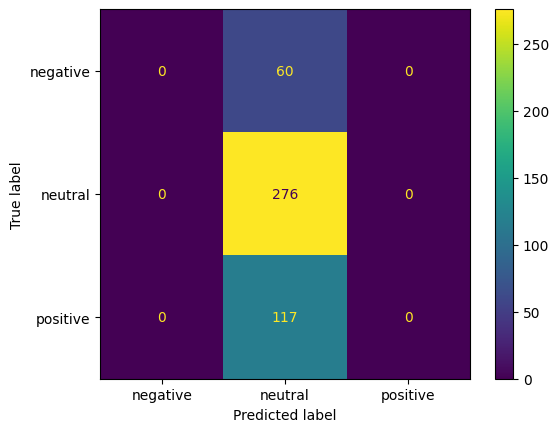

In [52]:
labels_test = np.array(result['test']['label'])
preds_test = np.array(result['test']['predictions'])
evaluate(labels_test,preds_test)

When allowing the weights of the transformers to be trained, the fine-tuned model gives terrible result. it classifies all sentences as neutral. This could be because roberta is a large language model which is originally trained on very large batch size. The batches and samples might be too small to optimize the model.


# 5. Fine-Tuning

## 5.1. Train with a balanced subset

I think the limitation of the fine-tuned model in classifying positive sentiment is due to the fact that the dataset contains highly imbalanced labels. Very high proportion of the labels are 'neutral'. Therefore, I try generating a subset with balanced label from the original dataset and train the model with it.


### 5.1.1. Model 3: Freeze Roberta with Balanced Training Set

I use all the same setting as model 1 but change the input data to a subset that I just created.

In [53]:
from datasets import Dataset
from datasets import concatenate_datasets

def generate_balanced_dataset(dataset):
  def select_balanced_subset(dataset, label, count):
    label_indices = []
    for i in range(dataset['train'].shape[0]):
      if dataset['train'][i]['label'] == label:
        label_indices.append(i)
    selected_indices = np.random.choice(label_indices, size=count, replace=False)
    return Dataset.from_dict(dataset['train'][selected_indices])

  label_counts = np.bincount(dataset['train']['label'])
  min_label_count = np.min(label_counts)
  subsets = []
  for label in range(3):
      count = min_label_count
      examples = select_balanced_subset(dataset, label, count)
      if(label == 0):
        balanced_dataset = examples
      else:
        balanced_dataset = concatenate_datasets([balanced_dataset,examples])
  return balanced_dataset

balanced_dataset = generate_balanced_dataset(tokenized_dataset)

In [54]:
balanced_dataset

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 729
})

In [55]:
model, tokenizer, config = load_pretrained_model()

load model from local path


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/twitter-roberta-base-sentiment-latest/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [56]:
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False)

balanced_dataset = balanced_dataset.map(tokenize_function)
balanced_dataset.save_to_disk('./model_input/balanced_dataset')

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/729 [00:00<?, ? examples/s]

In [60]:
from transformers import DataCollatorWithPadding
import os

if not os.path.exists('./model_input/tf_train_balanced/'):
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True, 
                                          return_tensors="tf")

  tf_train_balanced = model.prepare_tf_dataset(balanced_dataset, 
                      batch_size=8, shuffle=True, 
                      tokenizer=tokenizer,
                      collate_fn=data_collator
                    )
  tf.data.Dataset.save(tf_train_balanced, './model_input/tf_train_balanced/')
else:
  tf_train_balanced = tf.data.Dataset.load('./model_input/tf_train_balanced/')
tf_validation_dataset = tf.data.Dataset.load('./model_input/tf_test/')

In [61]:
model.roberta.trainable = False

# Import time module
import time
 
# record start time
start = time.time()

model.compile(metrics = 'accuracy')
model.fit(tf_train_balanced,validation_data = tf_validation_dataset, epochs = 4)

# record end time
end = time.time()
 
# print the difference between start
# and end time in secs
print("Execution Time:",
      (end-start), "s")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/4
91/91 [==============================] - 27s 124ms/step - loss: 0.5648 - accuracy: 0.8159 - val_loss: 0.3690 - val_accuracy: 0.8477
Epoch 2/4
91/91 [==============================] - 7s 75ms/step - loss: 0.3473 - accuracy: 0.8709 - val_loss: 0.3390 - val_accuracy: 0.8852
Epoch 3/4
91/91 [==============================] - 7s 79ms/step - loss: 0.3400 - accuracy: 0.8791 - val_loss: 0.5815 - val_accuracy: 0.7947
Epoch 4/4
91/91 [==============================] - 9s 96ms/step - loss: 0.3219 - accuracy: 0.8750 - val_loss: 0.2362 - val_accuracy: 0.9139
Execution Time: 64.73255705833435 s


In [62]:
model.save_pretrained('./model/freeze-roberta-balanced')

In [63]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
model = TFAutoModelForSequenceClassification.from_pretrained('./model/freeze-roberta-balanced/')
download_path = './cardiffnlp/twitter-roberta-base-sentiment-latest/'
tokenizer = AutoTokenizer.from_pretrained(download_path + 'tokenizer')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./model/freeze-roberta-balanced/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [64]:
from datasets import load_from_disk
import os

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False, return_tensors = 'tf')

if not os.path.exists('./results/freeze-roberta-balanced_trainset'):
  result = load_from_disk('./model_input/balanced_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/freeze-roberta-balanced_trainset')
else:
  result = load_from_disk('./results/freeze-roberta-balanced_trainset')

The performance on the training set is as follows.

Evaluation Metrics:
accuracy:  0.9286694101508917
f1:  [0.9375     0.9486166  0.89830508]
precision:  [0.94936709 0.91254753 0.92576419]
recall:  [0.92592593 0.98765432 0.87242798]

Label Counts:
predict:  {'0': 237, '1': 263, '2': 229}
true:  {'0': 243, '1': 243, '2': 243}


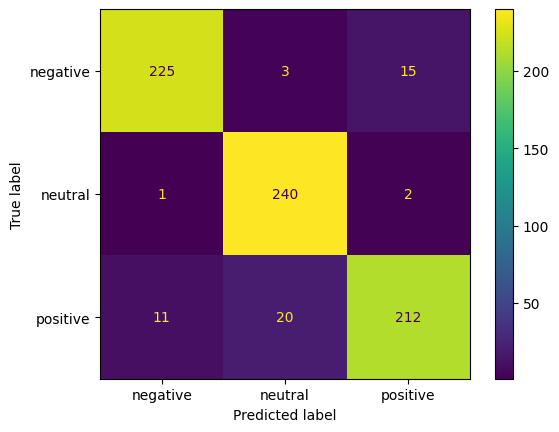

In [65]:
evaluate(result['label'],result['predictions'])

In [66]:
from datasets import load_from_disk
import os

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False, return_tensors = 'tf')

if not os.path.exists('./results/freeze-roberta-balanced'):
  result = load_from_disk('./model_input/tokenized_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/freeze-roberta-balanced')
else:
  result = load_from_disk('./results/freeze-roberta-balanced')

I decided to evaluate its performance based on the train and test dataset which are used to train other models. This is to make them comparable.

Train set:

Evaluation Metrics:
accuracy:  0.9403644395361679
f1:  [0.9202454  0.96671105 0.88409091]
precision:  [0.91463415 0.956942   0.91100703]
recall:  [0.92592593 0.97668161 0.85871965]

Label Counts:
predict:  {'0': 246, '1': 1138, '2': 427}
true:  {'0': 243, '1': 1115, '2': 453}


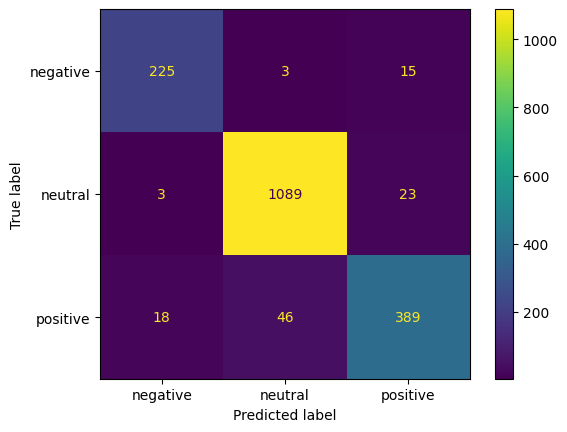

In [67]:
labels_train = result['train']['label']
preds_train = result['train']['predictions']
evaluate(labels_train,preds_train)

Test set:

Evaluation Metrics:
accuracy:  0.9293598233995585
f1:  [0.9        0.95855856 0.87445887]
precision:  [0.9        0.95340502 0.88596491]
recall:  [0.9        0.96376812 0.86324786]

Label Counts:
predict:  {'0': 60, '1': 279, '2': 114}
true:  {'0': 60, '1': 276, '2': 117}


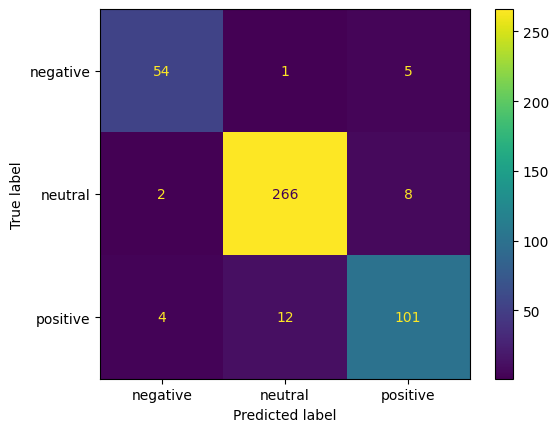

In [68]:
labels_test = result['test']['label']
preds_test = result['test']['predictions']
evaluate(labels_test,preds_test)

Although, the size of training set is drastically reduced, the model performs a little bit better in classifying positive sentiment. However, it performs worse in classifying negative sentiment. Some negative labels are classified as positive. 

It is possible that using larger balanced dataset would yield better result.

### 5.1.2. Model 4: Unfreeze All Layers with Balanced Training Set

I decided to train model 2 with the same balanced subset.

In addition, since the unfreeze model might need larger batches to train it, I increase the batch size to from 8 to 32 and increase the number of epochs from 4 to 8.


In [69]:
model, tokenizer, config = load_pretrained_model()

load model from local path


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/twitter-roberta-base-sentiment-latest/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [70]:
from transformers import DataCollatorWithPadding

balanced_dataset = load_from_disk('./model_input/balanced_dataset')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True, 
                                        return_tensors="tf")

tf_train_balanced_v2 = model.prepare_tf_dataset(balanced_dataset, 
                    batch_size=32, shuffle=True, 
                    tokenizer=tokenizer,
                    collate_fn=data_collator
                   )
tf.data.Dataset.save(tf_train_balanced_v2, './model_input/tf_train_balanced_v2/')
tf_validation_dataset = tf.data.Dataset.load('./model_input/tf_test/')

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [71]:
model.trainable = True

# Import time module
import time
 
# record start time
start = time.time()

model.compile(metrics = 'accuracy')
model.fit(tf_train_balanced_v2,validation_data = tf_validation_dataset, epochs = 8)

# record end time
end = time.time()
 
# print the difference between start
# and end time in secs
print("Execution Time:",
      (end-start), "s")

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/8
22/22 [==============================] - 67s 768ms/step - loss: 1.4167 - accuracy: 0.3281 - val_loss: 1.0798 - val_accuracy: 0.6093
Epoch 2/8
22/22 [==============================] - 12s 555ms/step - loss: 1.1357 - accuracy: 0.3111 - val_loss: 1.0386 - val_accuracy: 0.6093
Epoch 3/8
22/22 [==============================] - 14s 626ms/step - loss: 1.1136 - accuracy: 0.3224 - val_loss: 1.2539 - val_accuracy: 0.1325
Epoch 4/8
22/22 [==============================] - 14s 625ms/step - loss: 1.1226 - accuracy: 0.3551 - val_loss: 1.1588 - val_accuracy: 0.2583
Epoch 5/8
22/22 [==============================] - 11s 527ms/step - loss: 1.1082 - accuracy: 0.3381 - val_loss: 1.0912 - val_accuracy: 0.6093
Epoch 6/8
22/22 [==============================] - 12s 548ms/step - loss: 1.1117 - accuracy: 0.2983 - val_loss: 1.1076 - val_accuracy: 0.1325
Epoch 7/8
22/22 [==============================] - 11s 524ms/step - loss: 1.1050 - accuracy: 0.3480 - val_loss: 1.0670 - val_accuracy: 0.6093
Epoch 

In [72]:
model.save_pretrained('./model/roberta-unfreeze_balanced/')

In [73]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained('./model/roberta-unfreeze_balanced/')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./model/roberta-unfreeze_balanced/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [74]:
from datasets import load_from_disk
import os

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=False, return_tensors = 'tf')

if not os.path.exists('./results/roberta-unfreeze_balanced'):
  result = load_from_disk('./model_input/tokenized_dataset/')
  result = result.map(predict)
  result.save_to_disk('./results/roberta-unfreeze_balanced')
else:
  result = load_from_disk('./results/roberta-unfreeze_balanced')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
accuracy:  0.2501380452788515
f1:  [0.         0.         0.40017668]
precision:  [0.         0.         0.25013805]
recall:  [0. 0. 1.]

Label Counts:
predict:  {'0': 0, '1': 0, '2': 1811}
true:  {'0': 243, '1': 1115, '2': 453}


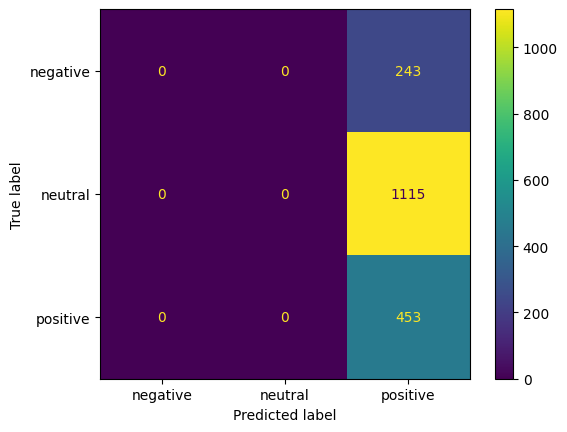

In [75]:
labels_train = result['train']['label']
preds_train = result['train']['predictions']
evaluate(labels_train,preds_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
accuracy:  0.2582781456953642
f1:  [0.         0.         0.41052632]
precision:  [0.         0.         0.25827815]
recall:  [0. 0. 1.]

Label Counts:
predict:  {'0': 0, '1': 0, '2': 453}
true:  {'0': 60, '1': 276, '2': 117}


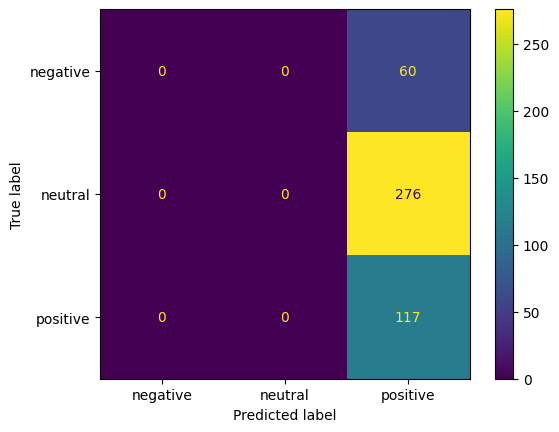

In [76]:
labels_test = result['test']['label']
preds_test = result['test']['predictions']
evaluate(labels_test,preds_test)

The model gives even worse results than the pretrained one. All labels are classified as positive. The accuracy is about the same as guessing. This is because of smaller sample size.

From checking with different sources, I found that instability is a common issue when RoBERTa is trained on small dataset.

## 5.2. Adjust training arguments

I think the unsatisfying result of the models with unfreeze transformers' weights could be solved by increasing the learning rate to make it converges faster within few epochs.

I tried several learning rate. However, the accuracy is at most 60%. This came to the conclusion that the model needs to be trained on large training samples.

In [85]:
model, tokenizer, config = load_pretrained_model()

load model from local path


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/twitter-roberta-base-sentiment-latest/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [86]:
tf_train_dataset = tf.data.Dataset.load('./model_input/tf_train/')
tf_validation_dataset = tf.data.Dataset.load('./model_input/tf_test/')

In [87]:
from tensorflow.keras.optimizers import AdamW

model.trainable = True

# Import time module
import time
 
# record start time
start = time.time()

model.compile(optimizer = AdamW(learning_rate=0.01),metrics = 'accuracy')
model.fit(tf_train_dataset,validation_data = tf_validation_dataset, epochs = 4)

# record end time
end = time.time()
 
# print the difference between start
# and end time in secs
print("Execution Time:",
      (end-start), "s")


No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/4
227/227 [==============================] - 149s 316ms/step - loss: 1.6739 - accuracy: 0.4959 - val_loss: 1.2426 - val_accuracy: 0.6093
Epoch 2/4
227/227 [==============================] - 44s 194ms/step - loss: 1.8183 - accuracy: 0.4964 - val_loss: 1.0239 - val_accuracy: 0.6093
Epoch 3/4
227/227 [==============================] - 35s 155ms/step - loss: 1.6475 - accuracy: 0.4931 - val_loss: 1.1680 - val_accuracy: 0.6093
Epoch 4/4
227/227 [==============================] - 43s 188ms/step - loss: 1.5923 - accuracy: 0.5124 - val_loss: 1.2039 - val_accuracy: 0.6093
Execution Time: 353.88037848472595 s


# 6. Conclusion

The best model that I could obtain is model 1 which is the one I freezed the transformers' weights.

Training the whole model gave lower accuracy at about 60%. To be able to achieve better result, larger dataset is required. The evidence for this is that in model 4 where I trained it with smaller balanced dataset, the accuracy significantly reduced.

Since fine-tuning only the classification head gave an extremely satisfying result with an accuracy of more than 90% in both train and validation set, there is no need to take more effort in training the entire model.

In addition, although our dataset is too small to get to this conclusion, using balanced training samples may improve the accuracy. To confirm this, we should test with larger balanced dataset.